# Project: Train a Quadcopter How to Fly

Design an agent to fly a quadcopter, and then train it using a reinforcement learning algorithm of your choice! 

Try to apply the techniques you have learnt, but also feel free to come up with innovative ideas and test them.

## Instructions

Take a look at the files in the directory to better understand the structure of the project. 

- `task.py`: Define your task (environment) in this file.
- `agents/`: Folder containing reinforcement learning agents.
    - `policy_search.py`: A sample agent has been provided here.
    - `agent.py`: Develop your agent here.
- `physics_sim.py`: This file contains the simulator for the quadcopter.  **DO NOT MODIFY THIS FILE**.

For this project, you will define your own task in `task.py`.  Although we have provided a example task to get you started, you are encouraged to change it.  Later in this notebook, you will learn more about how to amend this file.

You will also design a reinforcement learning agent in `agent.py` to complete your chosen task.  

You are welcome to create any additional files to help you to organize your code.  For instance, you may find it useful to define a `model.py` file defining any needed neural network architectures.

## Controlling the Quadcopter

We provide a sample agent in the code cell below to show you how to use the sim to control the quadcopter.  This agent is even simpler than the sample agent that you'll examine (in `agents/policy_search.py`) later in this notebook!

The agent controls the quadcopter by setting the revolutions per second on each of its four rotors.  The provided agent in the `Basic_Agent` class below always selects a random action for each of the four rotors.  These four speeds are returned by the `act` method as a list of four floating-point numbers.  

For this project, the agent that you will implement in `agents/agent.py` will have a far more intelligent method for selecting actions!

In [1]:
import random

class Basic_Agent():
    def __init__(self, task):
        self.task = task
    
    def act(self):
        new_thrust = random.gauss(450., 25.)
        return [new_thrust + random.gauss(0., 1.) for x in range(4)]

Run the code cell below to have the agent select actions to control the quadcopter.  

Feel free to change the provided values of `runtime`, `init_pose`, `init_velocities`, and `init_angle_velocities` below to change the starting conditions of the quadcopter.

The `labels` list below annotates statistics that are saved while running the simulation.  All of this information is saved in a text file `data.txt` and stored in the dictionary `results`.  

In [2]:
%load_ext autoreload
%autoreload 2

import csv
import numpy as np
from task import Task

# Modify the values below to give the quadcopter a different starting position.
runtime = 10.                                     # time limit of the episode
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'data.txt'                         # file name for saved results

# Setup
task = Task(init_pose, init_velocities, init_angle_velocities, runtime)
agent = Basic_Agent(task)
done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    while True:
        rotor_speeds = agent.act()
        _, _, done = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            break

Run the code cell below to visualize how the position of the quadcopter evolved during the simulation.

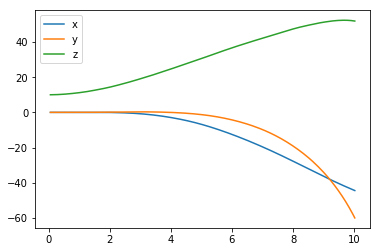

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

The next code cell visualizes the velocity of the quadcopter.

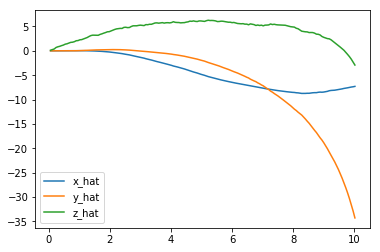

In [4]:
plt.plot(results['time'], results['x_velocity'], label='x_hat')
plt.plot(results['time'], results['y_velocity'], label='y_hat')
plt.plot(results['time'], results['z_velocity'], label='z_hat')
plt.legend()
_ = plt.ylim()

Next, you can plot the Euler angles (the rotation of the quadcopter over the $x$-, $y$-, and $z$-axes),

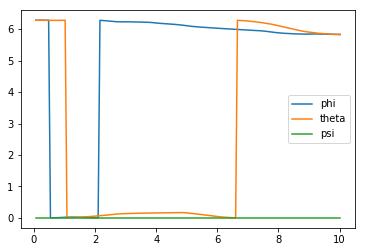

In [5]:
plt.plot(results['time'], results['phi'], label='phi')
plt.plot(results['time'], results['theta'], label='theta')
plt.plot(results['time'], results['psi'], label='psi')
plt.legend()
_ = plt.ylim()

before plotting the velocities (in radians per second) corresponding to each of the Euler angles.

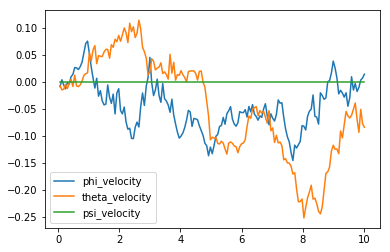

In [6]:
plt.plot(results['time'], results['phi_velocity'], label='phi_velocity')
plt.plot(results['time'], results['theta_velocity'], label='theta_velocity')
plt.plot(results['time'], results['psi_velocity'], label='psi_velocity')
plt.legend()
_ = plt.ylim()

Finally, you can use the code cell below to print the agent's choice of actions.  

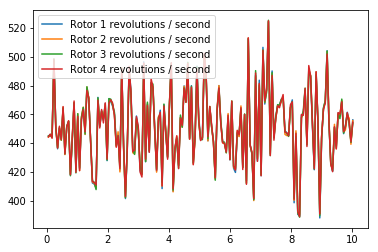

In [7]:
plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')
plt.legend()
_ = plt.ylim()

When specifying a task, you will derive the environment state from the simulator.  Run the code cell below to print the values of the following variables at the end of the simulation:
- `task.sim.pose` (the position of the quadcopter in ($x,y,z$) dimensions and the Euler angles),
- `task.sim.v` (the velocity of the quadcopter in ($x,y,z$) dimensions), and
- `task.sim.angular_v` (radians/second for each of the three Euler angles).

In the sample task in `task.py`, we use the 6-dimensional pose of the quadcopter to construct the state of the environment at each timestep.  However, when amending the task for your purposes, you are welcome to expand the size of the state vector by including the velocity information.  You can use any combination of the pose, velocity, and angular velocity - feel free to tinker here, and construct the state to suit your task.

## The Task

A sample task has been provided for you in `task.py`.  Open this file in a new window now. 

The `__init__()` method is used to initialize several variables that are needed to specify the task.  
- The simulator is initialized as an instance of the `PhysicsSim` class (from `physics_sim.py`).  
- Inspired by the methodology in the original DDPG paper, we make use of action repeats.  For each timestep of the agent, we step the simulation `action_repeats` timesteps.  If you are not familiar with action repeats, please read the **Results** section in [the DDPG paper](https://arxiv.org/abs/1509.02971).
- We set the number of elements in the state vector.  For the sample task, we only work with the 6-dimensional pose information.  To set the size of the state (`state_size`), we must take action repeats into account.  
- The environment will always have a 4-dimensional action space, with one entry for each rotor (`action_size=4`). You can set the minimum (`action_low`) and maximum (`action_high`) values of each entry here.
- The sample task in this provided file is for the agent to reach a target position.  We specify that target position as a variable.

The `reset()` method resets the simulator.  The agent should call this method every time the episode ends.  You can see an example of this in the code cell below.

The `step()` method is perhaps the most important.  It accepts the agent's choice of action `rotor_speeds`, which is used to prepare the next state to pass on to the agent.  Then, the reward is computed from `get_reward()`.  The episode is considered done if the time limit has been exceeded, or the quadcopter has travelled outside of the bounds of the simulation.

In the next section, you will learn how to test the performance of an agent on this task.

## The Agent

The sample agent given in `agents/policy_search.py` uses a very simplistic linear policy to directly compute the action vector as a dot product of the state vector and a matrix of weights. Then, it randomly perturbs the parameters by adding some Gaussian noise, to produce a different policy. Based on the average reward obtained in each episode (`score`), it keeps track of the best set of parameters found so far, how the score is changing, and accordingly tweaks a scaling factor to widen or tighten the noise.

Run the code cell below to see how the agent performs on the sample task.

In [9]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
from agents.policy_search import PolicySearch_Agent
from task import Task

num_episodes = 200
target_pos = np.array([0., 0., 10.])
task = Task(target_pos=target_pos)
agent = PolicySearch_Agent(task) 

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(reward, done)
        state = next_state
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {}".format(
                i_episode, agent.score, agent.best_score, agent.noise_scale), end="")  # [debug]
            break
    sys.stdout.flush()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Episode =  200, score =   5.250 (best =   6.031), noise_scale = 3.25

This agent should perform very poorly on this task.  And that's where you come in!

## Define the Task, Design the Agent, and Train Your Agent!

Amend `task.py` to specify a task of your choosing.  If you're unsure what kind of task to specify, you may like to teach your quadcopter to takeoff, hover in place, land softly, or reach a target pose.  

After specifying your task, use the sample agent in `agents/policy_search.py` as a template to define your own agent in `agents/agent.py`.  You can borrow whatever you need from the sample agent, including ideas on how you might modularize your code (using helper methods like `act()`, `learn()`, `reset_episode()`, etc.).

Note that it is **highly unlikely** that the first agent and task that you specify will learn well.  You will likely have to tweak various hyperparameters and the reward function for your task until you arrive at reasonably good behavior.

As you develop your agent, it's important to keep an eye on how it's performing. Use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that your agent is learning.

In [14]:
## TODO: Train your agent here.
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd
from agents.agent import DDPG
from task import Takeoff
import csv

num_episodes = 200
init_pose = np.array([0.,0.,10.,0.,0.,0.])
target_pos = np.array([0., 0., 100.])# Target takeoff to 100 units in  Z dimension  
task = Takeoff(target_pos=target_pos)
agent = DDPG(task)
best_score, worst_score = -1000.,1000.

reward_labels = ['episode', 'reward']
reward_results = {x : [] for x in reward_labels}

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    score = 0
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(action, reward, next_state, done)
        state = next_state
        score += reward
        best_score = max(best_score , score)
        worst_score = min(worst_score , score)
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f} , worst = {:7.3f})".format(
               i_episode, score, best_score, worst_score), end="")
            break
    reward_results['episode'].append(i_episode)
    reward_results['reward'].append(score)
    sys.stdout.flush()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Episode =  200, score = 531.694 (best = 545.522 , worst =   6.071)

No handles with labels found to put in legend.


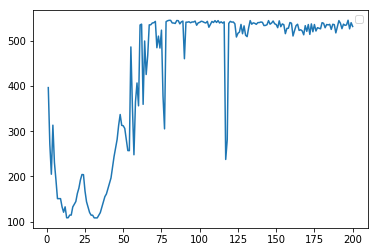

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(reward_results['episode'], reward_results['reward'])
plt.legend()
_ = plt.ylim()

## Plot the Rewards

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over multiple runs. 

In [ ]:
## TODO: Plot the rewards.

In [16]:
%load_ext autoreload
%autoreload 2

import csv
from task import Takeoff

# Modify the values below to give the quadcopter a different starting position.
runtime = 5000.                                     # time limit of the episode
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'data.txt'                         # file name for saved results

# Setup
task = Takeoff(init_pose, init_velocities, init_angle_velocities, runtime)
done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

# Run the simulation, and save the results.
state = agent.reset_episode()
total_reward = 0
while True:
    rotor_speeds = agent.act(state)
    next_state, reward, done = task.step(rotor_speeds)
    to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
    for ii in range(len(labels)):
        results[labels[ii]].append(to_write[ii])
    total_reward += reward
    state = next_state
    if done:
        print("Total episode reward : {}".format(total_reward))
        total_reward = 0
        break

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Total episode reward : 725.9872629762225


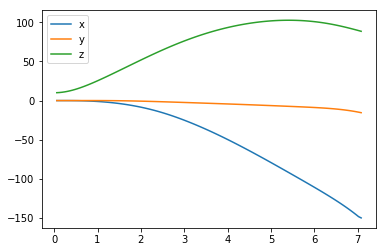

In [17]:
import  matplotlib.pyplot  as plt
%matplotlib inline

plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

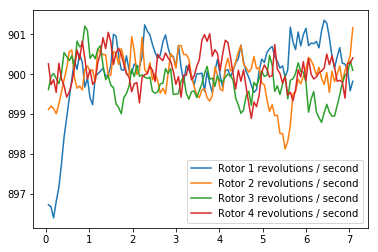

In [18]:
plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')
plt.legend()
_ = plt.ylim()

## Reflections

**Question 1**: Describe the task that you specified in `task.py`.  How did you design the reward function?

**Answer**:
I ended up defining the task as a simple "takeoff" task beginning at location [0,0,0] rising to [0,0,50]. So I expect the quadcopter to rise from the ground to 50 units in the Z dimension, with no movement in the other dimensions. 

I also explored a "Recovery" task where the quadcopter would begin at [0,0,50] but with velocity [-10.,-10.,-10] and recover to the starting position. I expanded the state space to include velocity for this task. It generated much the same results but the learning algorithm was less stabl (i.e. due to random initialisation it sometimes got locked into a low reward state). 

I only slightly expanded on the suggested reward function (see below). I recognised early on that I wanted to bound the reward function to control for excessive values driven by the positional difference function). I use a tanh function for this purpose. I immediately worked out the reward for staying in the air (the 1) was too insignificant vs the cost of the difference. The optimal outcome was to crash or go out of bounds as quickly as possible. I therefore reduced the size of the parameter on the difference between the target position and the actual position (searching across a range of small figures than the starting value of 0.3) until I achieved a much better outcome (the 0.005). 

reward = np.tanh(1 - 0.005*(abs(self.sim.pose[:3] - self.target_pos))).sum()

I noticed a large number of trained models (including the final one above) exhibited behaviours such as moving on the X or Y dimensions when they should stay at zero or shooting beyond the target on the Z dimension. To adjust for this I would try a reward function with an "in range" reward that is outsized and at the target.

**Question 2**: Discuss your agent briefly, using the following questions as a guide:

- What learning algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

**Answer**:

I utilised the Deep Deterministic Policy Gradient algorithm given its wide use and the fact it was suggested. I also explored using the Trust Region Policy Optimization however, either due to my poor implementation or its lack of applicability to the problem, it did not yield good results. I decided not to explore any further.

I tried a range of values for the key hyperparameters but eventually settled on the following (incl background to how I arrived to the values):
Experience replay buffer = 100 (read research warning about dangers of large replay buffers)
Experience replay batch size = 10 (randomly chosen fraction of replay buffer)
Soft target update rate = 0.001 (tried altering provided example value by factors of ten)
Actor learning rate = 0.0001 (looked for widely used values then adjusted by factors of ten)
Critic learning rate = 0.001 (looked for widely used values then adjusted by factors of ten)
Gamma = 0.99 (kept to provided value)

I used the following neural network architecture:

Actor
Dense(units=400) + L2 Regularisation + BatchNorm + Leaky ReLu Activation (Alpha=0.3)
Dense(units=300) + L2 Regularisation + BatchNorm + Leaky ReLu Activation (Alpha=0.3)
Dense(with RandomUniform Weight initialisation) + Sigmoid Activation

Critic State Pathway
Dense(units=400) + L2 Regularisation + BatchNorm + Leaky ReLu Activation (Alpha=0.3)
Dense(units=300) + L2 Regularisation
Critic Action Pathway
Dense(units=300) + L2 Regularisation
Combining with Leaky ReLu Activation

**Question 3**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**Answer**:

The agent did not show much progress learning the task at first using the base example provided by Udacity. I then restricted the reward function to values between -1 and 1 and rescaled the values in the reward function and changed the network structure by reducing the number of layers and boosting the units. This was based on my reading of a number of research articles that served as good examples. The agent at this point started to learn.

Deep Reinforcement Learning as a topic has provided me with a long and gradual learning curve. Lots of trial and error and looking for different ways to approach the problem at hand. During this particular project there were two aha moments: 1) recognising the importance of the reward function and network architecture 2) the importance of hyperparameters to effective learning and how there isnt any standard rules to follow, more a matter of testing various values and deducing what is happening from the results.

The performance of the final agent (as shown above) was on average 520 over the last 100 episodes. The learning agent showed little promise for the first 25-50 episodes before suddenly trending upwards, reaching a high level of rewards at 75 episodes  where it remained to the end of the 200 episodes. This behaviour consistently repeated itself with the chosen network architecture and hyperparameters.

Interestingly the single episode result shown in the "Plot the Rewards" section above showed a much higher reward outcome. This occurred repeatedly. It can be seen the agent pushes towards 100 on the Z dimension often at the cost of moving on the X or Y dimension away from the target on these dimensions. This must be a necessary consequence of the agent pushing as hard as possible to 100 on the Z. The rotor speeds sit at the maximum through the entire episode.

**Question 4**: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)
- Did you find anything interesting in how the quadcopter or your agent behaved?

**Answer**:

The hardest part was understanding how the Actor-Critic, Agent, and Task scripts interacted. THere was a significant amount of time spent tracing data through the model to help my own understanding. Once this was done I felt more comfortable exploring variations of the model (e.g. adding to the state space).

The two interesting observations I found with the quadcopter were: 1) the tendency to dive to 0 on the Z dimensions causing the sim to go out of bounds. THis was because the reward function was unbounded and heavily punished the distance to target. Once the tanh function and cost for distance to target were changed then this behaviour stopped. 2) the final agent sits at maximum rotor speed and is happy to move some distance on the X and Y dimensions in its effort to get to 100 on the Z dimension.